In [8]:
!python3 --version

Python 3.10.12


# **Download data**

In [1]:
%%capture test
!wget 'https://drive.google.com/uc?export=download&id=1LV_kUVFsz5eN0lul1jNVjVX6lpChNU9B' -O 'dataset.zip'
!unzip -o dataset.zip -d 'data'


# **Setup env**

In [6]:
!pip install -r req.txt

In [4]:
!python3 -m nltk.downloader wordnet
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /home/mike/nltk_data...
unzip:  cannot find or open /root/nltk_data/corpora/wordnet.zip, /root/nltk_data/corpora/wordnet.zip.zip or /root/nltk_data/corpora/wordnet.zip.ZIP.


In [5]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.7 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Раскоментить если на Kaggle

In [ ]:
# import nltk 

# import subprocess
# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# **Imports**

In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import mailparser
from string import punctuation
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import spacy
from random import choice
from IPython.display import display, HTML

# **Global vars**

In [19]:
spam_data_path = './data/spam/'
ham_data_path = './data/ham/'
spam_data = list(map(lambda a: spam_data_path + a, os.listdir(spam_data_path)))
ham_data = list(map(lambda a: ham_data_path + a, os.listdir(ham_data_path)))
stop_symbols = punctuation.replace('?', '').replace('!', '').replace('.', '')
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_md")


In [20]:
len(spam_data), len(ham_data)

(1397, 2551)

В данных присутствует дизбаланс классов.

# **Global functions**

In [21]:
def readDataFromFile(path):
    with open(path, 'r') as f:
        d = f.read()
    return d


def cleanersPipeline(text: str, cleaners: list):
    for cleaner in cleaners:
        text = cleaner(text)
    return text


# **First lookup**

Для более удобной работы с письмами (и что-бы не писать свой парсер) будем использовать библиотеку `mail-parser`. Благодаря ему мы можем выделять только тело письма.

In [22]:
mail = mailparser.parse_from_file(spam_data[2])
mail.body

'<<< SPECIAL REVISED PRICE AS OF 5/24/2002 - HURRY QUANITIES WILL BE LIMITED >>>\n\n\nAttention: Are you buying from the "Information America" type companies for .10-.15 cents per record, we sell the same types of data for 1000\'s of records per penny! As a matter of fact several of these companies use and sell our data since did not have the skills to compile / append the newer internet fields such as web site info and  e m a i l  information. \n\nPlease Read On...\n\nThe Ultimate Traditional & Internet Marketing Tool, Introducing the "M A S T E R  D I S C  2002" versions 4.00-4.10, now released its MASSIVE 11 disc set with over 145 Million database records (18-20 gigabytes of databases) for marketing to companies, people, via  e m a i l, fax, phone and mailing addresses Worldwide!\n\nCOMPLETE 11 DISC SET IS ALL OF THE MARKETING DATA YOU WILL NEED FOR 2002 & 2003 (Put your service or product out for the world to see!)\n\nWe\'ve been slashing prices once again to get you hooked on our 

В итоге имеем документ с html-вёрсткой. Для удаления тэгов воспользуемся `BeautifulSoup`.

Дата, ip и почта, при отсутствии последовательности поступления писем, будут бесполезны. Так-же как и большинство символов и декаративных элементов - линий.

Напишем функции для отчистки текста от мусора.

In [23]:
# Тэги для заполнения мусора
month_filler = ''
day_of_week_filler = ''
time_filler = ''
mail_filler = ''
date_filler = ''
href_filler = ''
enum_filler = ''
num_filler = ''

# Форматы для фильтров
re_mails = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
re_time = re.compile(r'\d+:\d+:\d+')
re_date1 = re.compile(r'\w{3} \d\d \d\d:\d\d:\d\d \d\d\d\d',)
re_date2 = re.compile(r'\d\d \w{3} \d\d\d\d \d\d:\d\d:\d\d',)
re_lines = re.compile(r'[-_=]+')
re_href = re.compile('http[s]?://.+')
re_site = re.compile('\w+\.\w+')

# Фильтры
mail_cleaner = lambda text: re.sub(re_mails, mail_filler, text)
space_cleaner = lambda text: re.sub(r'\s+', ' ', text)
eol_cleaner = lambda text: re.sub(r'\n', '.', text)
time_cleaner = lambda text: re.sub(re_time, time_filler, text)
date_cleaner = lambda text: re.sub(re_date2, date_filler, re.sub(re_date1, '', text))
lines_cleaner = lambda text: re.sub(re_lines, '', text)
href_cleaner = lambda text: re.sub(re_href, href_filler, text)
site_cleaner = lambda text: re.sub(re_site, href_filler, text)
num_cleaner = lambda text: re.sub(r'\d+', num_filler, text)
shorts_cleaner = lambda text: re.sub(r'\w\.', num_filler, text)


def dayOfWeekCleaner(text):
    dow = ['Mon', 'Sat', 'Wed', 'Tues', 'Thurs', 'Fri', 'Sun']
    for i in dow:
        text = text.replace(i, day_of_week_filler)
    return text


def replaceSymbols(text):
    for i in stop_symbols:
        text = text.replace(f' {i} ', ' ')
        text = text.replace(f'{i} ', ' ')
        text = text.replace(f' {i}', ' ')
        text = text.replace(i, ' ')
    text = text.replace('.', '. ')
    text = text.replace('!', '! ')
    text = text.replace('?', '? ')
    return text


def replaceEnums(text):
    text = re.sub(r'\d+th', enum_filler, text)
    text = re.sub(r'\d+st', enum_filler, text)
    text = re.sub(r'\d+th', enum_filler, text)
    text = re.sub(r'\d+nd', enum_filler, text)
    return text


def removeSingle(text):
    return ' '.join([i for i in text.split(' ') if len(i) != 1])


def lower_formator(text):
    return text.lower()


def replaceAllSymbols(text):
    for i in punctuation:
        text = text.replace(i, ' ')
    return text
        


# Создадим стандартную стратегию для нормализации текстов:

- удаляются все символы-пунктуации;
- все слова приводятся к нижнему регистру;
- удаляются все цифры;
- удаляются все сокращения;
- удаляются элементы с длиной 1;
- удаляются почтовые адреса;
- удаляются ссылки на сайты;

In [24]:
std_cleaner_pipline_strategy = [
    href_cleaner, 
    replaceEnums, 
    lines_cleaner, 
    dayOfWeekCleaner, 
    time_cleaner, 
    space_cleaner, 
    mail_cleaner, 
    replaceSymbols, 
    site_cleaner, 
    num_cleaner, 
    shorts_cleaner, 
    removeSingle, 
    space_cleaner, 
    lower_formator
]

Выведим результат

In [25]:
cleanersPipeline(
    BeautifulSoup(mail.body, 'html.parser').text, 
    std_cleaner_pipline_strategy
)

' special revised price as of hurry quanities will be limited attention are you buying from the information america type companies for cents per record we sell the same types of data for of records per penny! as matter of fact several of these companies use and sell our data since did not have the skills to compile append the newer internet fields such as web site info and informatio please read the ultimate traditional internet marketing tool introducing the versions now released its massive disc set with over million database records gigabytes of databases for marketing to companies people via fax phone and mailing addresses worldwide! complete disc set is all of the marketing data you will need for put your service or product out for the world to see! we ve been slashing prices once again to get you hooked on our leads data product the full disc set ver contains all databases all software titles all demos more then million records include an address and many many other useful fields

Т.к. для первого просмотра этого будет достаточно - обернём в функцию.

In [26]:
def stdTextNormalizer(path):
    mail = mailparser.parse_from_file(path)
    text = BeautifulSoup(mail.body, 'html.parser').text
    return cleanersPipeline(
        text, 
        std_cleaner_pipline_strategy
    )

# **Create dataset**

In [27]:
df_with_std_clean = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_std_clean['texts'] = df_with_std_clean['mails'].map(stdTextNormalizer)
df_with_std_clean

/tmp/ipykernel_32/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
/tmp/ipykernel_32/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


,mails,class,texts
0,./data/spam/00490.09cc8eacfd07338802c3ea0e7f07...,1.0,increase your gas mileageby up to no tools re...
1,./data/spam/01328.b23902de23cb3ca1f33345172823...,1.0,hello are you satisfied with your isp? do you ...
2,./data/spam/00491.008606ae6538b605f82b61913814...,1.0,special revised price as of hurry quanities w...
3,./data/spam/01204.75323a3e0d38fe7a107bd0102daf...,1.0,hello my name is natali live in petersberg an...
4,./data/spam/00687.52860b94e6aec19d0286673d705f...,1.0,you are receiving this email because you regi...
...,...,...,...
3943,./data/ham/0539.6430d7b1bde02782a28fef081b4224fc,0.0,why should i? on sep geege schuman wrote quitc...
3944,./data/ham/1701.39d6d3507aa62320295032f0c0e4435c,0.0,date sep edt from dayv gastonguay just instal...
3945,./data/ham/2292.280a5c73c09974136e1f31c118ed6b2f,0.0,url date not supplied the tmobile sidekick the...
3946,./data/ham/2345.f7e1e6af67f433af40d8f153ee5fa446,0.0,url date this talk is not supposed to be techn...


Выберим датасет для первого прогона

In [28]:
df = df_with_std_clean.copy()

# **Deeper research**

Рассмотрим информацию о размере словаря

In [29]:
d = sum(df['texts'].apply(lambda a: a.split()).apply(lambda a: list(filter(lambda b: len(b) > 0, a))).to_list(), [])
n = pd.Series(d).value_counts()
n.describe()

count    41838.000000
mean        21.551413
std        335.886430
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      38751.000000
Name: count, dtype: float64

In [30]:
n[(n < 8000) & (n>100)].describe()

count    1084.000000
mean      420.964022
std       730.005201
min       101.000000
25%       133.000000
50%       199.500000
75%       367.250000
max      7692.000000
Name: count, dtype: float64

<Axes: >

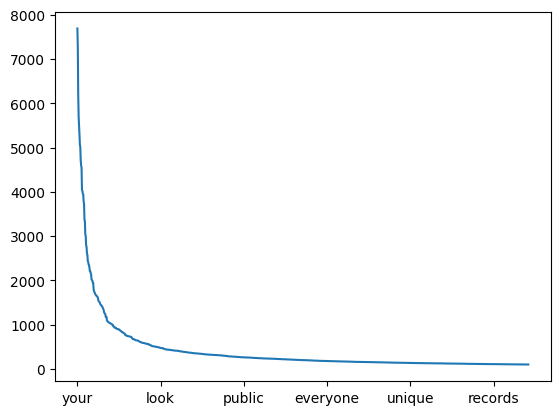

In [31]:
n[(n < 8000) & (n>100)].plot()

# **Model selection**

## Train test split

Разделим данные на тренеровочную и тестовую. Для невилирования возможности переобучения укажем параметр `stratify`

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])

## Vectorizer

Выберем метод векторизации текстов.

Т.к. язык у нас английский, то задача становится сильно проще и использование сложных моделей (в том числе и моделей векторизации) будет избыточно. Поэтому проверим первую стратегию векторизции текстов - векторизуем все слова и ищем среднее значение по каждому параметру.

Для данной задачи была выбранна модель Word2Vec. Но стоит учесть, что слова не находящиеся в словаре данной модели будут векторизованны лиш как [UNK] тэг

In [33]:
w2v_model = Word2Vec(sentences=X_train.map(lambda a: a.split(' ')).to_list(), vector_size=256, window=5, min_count=1, workers=4)

In [34]:
unk_word = np.zeros(256)

In [35]:
def vectorizerByW2V(word):
    try:
        return w2v_model.wv[word]
    except:
        return unk_word
    

## Prepear data to models

In [36]:
def textEmbedingByMeanPooling(data, model):
    x = list()
    for text in data:
        v = None
        k = 0
        for word in text.split(' '):
            if k==0:
                v = model(word).copy()
            else:
                v += model(word).copy()
            k+=1
        v = v/k
        x.append(v.tolist())
    return np.array(x)
            
            

In [37]:
x_train_prep = textEmbedingByMeanPooling(X_train, vectorizerByW2V)
x_train_prep.shape, x_train_prep.dtype

((2763, 256), dtype('float64'))

In [38]:
x_test_prep = textEmbedingByMeanPooling(X_test, vectorizerByW2V)
x_test_prep.shape, x_test_prep.dtype

((1185, 256), dtype('float64'))

## Model

In [39]:
catboost_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_model.fit(x_train_prep,
          y_train,
          verbose=False)

In [40]:
print(classification_report(y_train, catboost_model.predict(x_train_prep)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1785
         1.0       1.00      1.00      1.00       978

    accuracy                           1.00      2763
   macro avg       1.00      1.00      1.00      2763
weighted avg       1.00      1.00      1.00      2763



Казалось-бы получили переобучение

In [41]:
print(classification_report(y_test, catboost_model.predict(x_test_prep)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       766
         1.0       0.98      0.96      0.97       419

    accuracy                           0.98      1185
   macro avg       0.98      0.98      0.98      1185
weighted avg       0.98      0.98      0.98      1185



А нет-с

In [42]:
confusion_matrix(y_test, catboost_model.predict(x_test_prep))

array([[759,   7],
       [ 17, 402]])

В принципе уже не плохо. Сохраним модель и попытаемся добить до 99.


In [43]:
catboost_model.save_model("model.cbm")

In [44]:
w2v_model.save('vecctorizer.w2v')

# **Level up**

## Изменим стратегию нормализации текстов

Воспользуемс `nltk` для лематизации и токенизации текстов

In [45]:
nltk_cleaner_pipline_strategy = [
    href_cleaner, 
    replaceEnums, 
    lines_cleaner, 
    dayOfWeekCleaner, 
    time_cleaner, 
    space_cleaner, 
    mail_cleaner, 
    site_cleaner, 
    num_cleaner, 
    shorts_cleaner, 
    removeSingle, 
    space_cleaner, 
    lower_formator
]

In [46]:
def nltkTextNormalization(path):
    mail = mailparser.parse_from_file(path)
    text = BeautifulSoup(mail.body, 'html.parser').text
    text = cleanersPipeline(
        text, 
        nltk_cleaner_pipline_strategy
    )
    text = ' '.join([lemmatizer.lemmatize(i) for i in word_tokenize(text)])
    for i in punctuation:
        text = text.replace(i, '')
    text = space_cleaner(text)
    return removeSingle(text)


In [47]:
nltkTextNormalization(spam_data[0])

'increase your gas mileageby up to no tool required improves power maximizes energy improves mileage improves torque cleaner engine smoother engine reduces emission by protects catalytic converter prevents diesel gelling improves spark plug life maintenance free pay for itself within day installs in second simple device that easily snap over your fuel lin anyone can do it guaranteed full refund if you are not satisfied with the result within three month from the date of purchas click here how to unsubscribe you received this email because you are registered at one of our web site or on one of our partner site if you do not want to receive partner email offer or any email marketing from please click her boy friendvjfzktypnmsjkyl acmjeakrgxyonwoyljixyzlhlvl'

In [48]:
df_with_nltk_normalization = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_nltk_normalization['texts'] = df_with_nltk_normalization['mails'].map(nltkTextNormalization)
df_with_nltk_normalization

/tmp/ipykernel_32/1258180473.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
/tmp/ipykernel_32/1258180473.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


,mails,class,texts
0,./data/spam/00490.09cc8eacfd07338802c3ea0e7f07...,1.0,increase your gas mileageby up to no tool requ...
1,./data/spam/01328.b23902de23cb3ca1f33345172823...,1.0,hello are you satisfied with your isp do you h...
2,./data/spam/00491.008606ae6538b605f82b61913814...,1.0,special revised price of hurry quanities will...
3,./data/spam/01204.75323a3e0d38fe7a107bd0102daf...,1.0,hello my name is natali live in and am looking...
4,./data/spam/00687.52860b94e6aec19d0286673d705f...,1.0,you are receiving this email because you regis...
...,...,...,...
3943,./data/ham/0539.6430d7b1bde02782a28fef081b4224fc,0.0,why should on sep geege schuman wrote quitcher...
3944,./data/ham/1701.39d6d3507aa62320295032f0c0e4435c,0.0,date sep edt from dayv gastonguay just install...
3945,./data/ham/2292.280a5c73c09974136e1f31c118ed6b2f,0.0,url date not supplied the tmobile sidekick the...
3946,./data/ham/2345.f7e1e6af67f433af40d8f153ee5fa446,0.0,url date this talk is not supposed to be techn...


In [49]:
d = sum(df_with_nltk_normalization['texts'].apply(lambda a: a.split()).apply(lambda a: list(filter(lambda b: len(b) > 0, a))).to_list(), [])
n = pd.Series(d).value_counts()
n.describe()

count    36135.000000
mean        24.600194
std        363.852449
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      38721.000000
Name: count, dtype: float64

In [50]:
n[(n < 8000) & (n>100)].describe()

count    1082.000000
mean      440.976895
std       743.693490
min       101.000000
25%       136.000000
50%       208.000000
75%       399.500000
max      7682.000000
Name: count, dtype: float64

<Axes: >

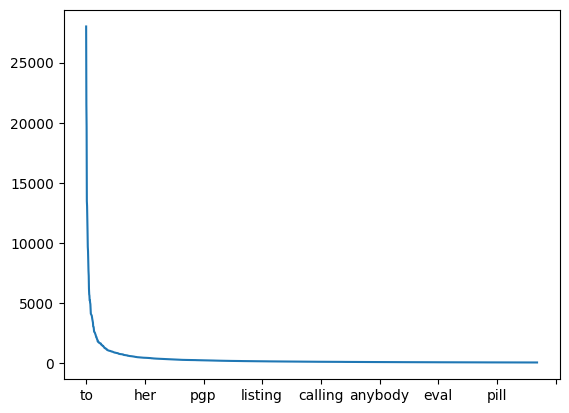

In [51]:
n[(n < 30000) & (n>50)].plot()

In [52]:
usefull_words = n[(n < 8000) & (n>100)].index.to_list()

def uselessWordsRemover(text):
    for i in text.split(' '):
        if not (text in usefull_words):
            text = text.replace(i, '')
    return space_cleaner(text)

In [53]:
df_with_nltk_normalization['texts_for_vec'] = df_with_nltk_normalization['texts'].map(uselessWordsRemover)

In [54]:
df_with_nltk_normalization

,mails,class,texts,texts_for_vec
0,./data/spam/00490.09cc8eacfd07338802c3ea0e7f07...,1.0,increase your gas mileageby up to no tool requ...,ol rque l t wh se se t fer marketg acmjeakrgx...
1,./data/spam/01328.b23902de23cb3ca1f33345172823...,1.0,hello are you satisfied with your isp do you h...,r r r h virtuy m nuer a furr mion mion l wh m...
2,./data/spam/00491.008606ae6538b605f82b61913814...,1.0,special revised price of hurry quanities will...,se ner b mio ol wh base base r wld en r ctas ...
3,./data/spam/01204.75323a3e0d38fe7a107bd0102daf...,1.0,hello my name is natali live in and am looking...,lookg th ternet ly
4,./data/spam/00687.52860b94e6aec19d0286673d705f...,1.0,you are receiving this email because you regis...,r f rae r bse f ntact r cusmer cse k ir r cus...
...,...,...,...,...
3943,./data/ham/0539.6430d7b1bde02782a28fef081b4224fc,0.0,why should on sep geege schuman wrote quitcher...,temr ad y ted sh clos se numr mo use cive use...
3944,./data/ham/1701.39d6d3507aa62320295032f0c0e4435c,0.0,date sep edt from dayv gastonguay just install...,chec check out th err usrlollibsiteiclie lest...
3945,./data/ham/2292.280a5c73c09974136e1f31c118ed6b2f,0.0,url date not supplied the tmobile sidekick the...,francco thk gog th competir compd wh or spir ...
3946,./data/ham/2345.f7e1e6af67f433af40d8f153ee5fa446,0.0,url date this talk is not supposed to be techn...,me y en ha en busess f or


In [55]:
df = df_with_nltk_normalization.copy()

In [56]:
X_train_nltk, X_test_nltk, y_train_nltk, y_test_nltk = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])

In [57]:
w2v_nltk_model = Word2Vec(sentences=df['texts_for_vec'].map(lambda a: a.split(' ')).to_list(), vector_size=128, window=5, min_count=1, workers=4)

In [58]:
unk_word = np.zeros(128)
def vectorizerByNLTKW2V(word):
    try:
        return w2v_nltk_model.wv[word]
    except:
        return unk_word
    

In [59]:
x_train_nltk_prep = textEmbedingByMeanPooling(X_train_nltk, vectorizerByNLTKW2V)
x_test_nltk_prep = textEmbedingByMeanPooling(X_test_nltk, vectorizerByNLTKW2V)


In [60]:
catboost_nltk_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_nltk_model.fit(x_train_nltk_prep,
          y_train_nltk,
          verbose=False)

In [61]:
print(classification_report(y_test_nltk, catboost_nltk_model.predict(x_test_nltk_prep)))

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       766
         1.0       0.78      0.58      0.67       419

    accuracy                           0.80      1185
   macro avg       0.79      0.75      0.76      1185
weighted avg       0.79      0.80      0.79      1185



In [62]:
confusion_matrix(y_test_nltk, catboost_nltk_model.predict(x_test_nltk_prep))

array([[699,  67],
       [175, 244]])

Результат ухудшился $\Rightarrow$ уменьшать вокабуляр бессмысленно (по крайне мере основываясь на частоте встречаемости слов (распределении слов))

## Изменим векторизатор

Воспользуемся `Spacy`

In [63]:
df_with_std_clean = pd.DataFrame({'mails': spam_data + ham_data, 'class': np.ones(len(spam_data)).tolist() + np.zeros(len(ham_data)).tolist()})
df_with_std_clean['texts'] = df_with_std_clean['mails'].map(stdTextNormalizer)
df_with_std_clean

/tmp/ipykernel_32/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text
/tmp/ipykernel_32/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


,mails,class,texts
0,./data/spam/00490.09cc8eacfd07338802c3ea0e7f07...,1.0,increase your gas mileageby up to no tools re...
1,./data/spam/01328.b23902de23cb3ca1f33345172823...,1.0,hello are you satisfied with your isp? do you ...
2,./data/spam/00491.008606ae6538b605f82b61913814...,1.0,special revised price as of hurry quanities w...
3,./data/spam/01204.75323a3e0d38fe7a107bd0102daf...,1.0,hello my name is natali live in petersberg an...
4,./data/spam/00687.52860b94e6aec19d0286673d705f...,1.0,you are receiving this email because you regi...
...,...,...,...
3943,./data/ham/0539.6430d7b1bde02782a28fef081b4224fc,0.0,why should i? on sep geege schuman wrote quitc...
3944,./data/ham/1701.39d6d3507aa62320295032f0c0e4435c,0.0,date sep edt from dayv gastonguay just instal...
3945,./data/ham/2292.280a5c73c09974136e1f31c118ed6b2f,0.0,url date not supplied the tmobile sidekick the...
3946,./data/ham/2345.f7e1e6af67f433af40d8f153ee5fa446,0.0,url date this talk is not supposed to be techn...


In [64]:
from tqdm import tqdm
tqdm.pandas()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df['texts'], df['class'], test_size=0.3, stratify=df['class'])
x_test_spacy_prep = X_test.progress_map(lambda a: nlp(a).vector)
x_train_spacy_prep = X_train.progress_map(lambda a: nlp(a).vector)

    

100%|██████████| 2763/2763 [02:17<00:00, 20.08it/s]


In [66]:
catboost_spacy_model = CatBoostClassifier(iterations=100,
#  task_type="GPU",
#  devices='0:1'
)
catboost_spacy_model.fit(x_train_spacy_prep.to_list(),
          y_train.to_list(),
          verbose=False)

In [67]:
print(classification_report(y_test.to_list(), catboost_spacy_model.predict(x_test_spacy_prep.to_list())))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       766
         1.0       0.98      0.96      0.97       419

    accuracy                           0.98      1185
   macro avg       0.98      0.97      0.98      1185
weighted avg       0.98      0.98      0.98      1185



In [68]:
confusion_matrix(y_test.to_list(), catboost_spacy_model.predict(x_test_spacy_prep.to_list()))

array([[759,   7],
       [ 18, 401]])

Чуть-чуть получше стало.

In [86]:
catboost_model.save_model("model_spacy.cbm")

# **Results**

В итоге была выбранна комбинация из `Catboost` и `Spacy`

## Пример выполнения на спаме

In [78]:
spam_data_for_predict = [choice(spam_data) for i in range(10)]

In [79]:
display(HTML(mailparser.parse_from_file(spam_data_for_predict[0]).body))

In [72]:
predict(
    model=lambda a: catboost_spacy_model.predict(a), 
    normalizer=stdTextNormalizer, 
    vectorizer=lambda a: nlp(a).vector, 
    texts=spam_data_for_test
)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Пример выполнения на не спам

In [81]:
ham_data_for_predict = [choice(ham_data) for i in range(10)]

In [82]:
display(HTML(mailparser.parse_from_file(ham_data_for_predict[0]).body))

In [85]:
predict(
    model=lambda a: catboost_spacy_model.predict(a), 
    normalizer=stdTextNormalizer, 
    vectorizer=lambda a: nlp(a).vector, 
    texts=ham_data_for_predict
)

/tmp/ipykernel_32/3795023322.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(mail.body, 'html.parser').text


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])